In [384]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
from pysal.explore import esda
from pysal.lib import weights
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import BallTree
from scipy.stats import zscore
import seaborn as sns
import matplotlib.pyplot as plt
from pysal.explore import esda
from scipy.stats import gaussian_kde
from spreg import OLS, ML_Error
from spreg import diagnostics as diag
from scipy.spatial.distance import cdist

In [385]:
#Update the Database with relative paths
current_dir = os.getcwd()
UnEmployData = pd.read_csv(os.path.join(current_dir, 'Unemployment in India.csv'))
shapefile_dir = os.path.join(current_dir, 'IND_adm', 'IND_adm1.shp')

In [386]:
UnEmployData

,Region,Date,Frequency,Estimated Unemployment Rate (%),Estimated Employed,Estimated Labour Participation Rate (%),Area
0,Andhra Pradesh,31-05-2019,Monthly,3.65,11999139.0,43.24,Rural
1,Andhra Pradesh,30-06-2019,Monthly,3.05,11755881.0,42.05,Rural
2,Andhra Pradesh,31-07-2019,Monthly,3.75,12086707.0,43.50,Rural
3,Andhra Pradesh,31-08-2019,Monthly,3.32,12285693.0,43.97,Rural
4,Andhra Pradesh,30-09-2019,Monthly,5.17,12256762.0,44.68,Rural
...,...,...,...,...,...,...,...
763,NaN,NaN,NaN,NaN,NaN,NaN,NaN
764,NaN,NaN,NaN,NaN,NaN,NaN,NaN
765,NaN,NaN,NaN,NaN,NaN,NaN,NaN
766,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [387]:
#Remove Null Values
UnEmployData = UnEmployData.dropna()
UnEmployData

,Region,Date,Frequency,Estimated Unemployment Rate (%),Estimated Employed,Estimated Labour Participation Rate (%),Area
0,Andhra Pradesh,31-05-2019,Monthly,3.65,11999139.0,43.24,Rural
1,Andhra Pradesh,30-06-2019,Monthly,3.05,11755881.0,42.05,Rural
2,Andhra Pradesh,31-07-2019,Monthly,3.75,12086707.0,43.50,Rural
3,Andhra Pradesh,31-08-2019,Monthly,3.32,12285693.0,43.97,Rural
4,Andhra Pradesh,30-09-2019,Monthly,5.17,12256762.0,44.68,Rural
...,...,...,...,...,...,...,...
749,West Bengal,29-02-2020,Monthly,7.55,10871168.0,44.09,Urban
750,West Bengal,31-03-2020,Monthly,6.67,10806105.0,43.34,Urban
751,West Bengal,30-04-2020,Monthly,15.63,9299466.0,41.20,Urban
752,West Bengal,31-05-2020,Monthly,15.22,9240903.0,40.67,Urban


In [388]:
#Remove Leading and Trailing Spaces in Column Names
UnEmployData.columns = UnEmployData.columns.str.strip()

#Get Region, Estimated Unemployment Rate, Estimated Employed, Estimated Labour Participation Rate
UnEmployData = UnEmployData[['Region', 'Estimated Unemployment Rate (%)', 'Estimated Employed', 'Estimated Labour Participation Rate (%)']]
UnEmployData

,Region,Estimated Unemployment Rate (%),Estimated Employed,Estimated Labour Participation Rate (%)
0,Andhra Pradesh,3.65,11999139.0,43.24
1,Andhra Pradesh,3.05,11755881.0,42.05
2,Andhra Pradesh,3.75,12086707.0,43.50
3,Andhra Pradesh,3.32,12285693.0,43.97
4,Andhra Pradesh,5.17,12256762.0,44.68
...,...,...,...,...
749,West Bengal,7.55,10871168.0,44.09
750,West Bengal,6.67,10806105.0,43.34
751,West Bengal,15.63,9299466.0,41.20
752,West Bengal,15.22,9240903.0,40.67


In [389]:
#Get the Region and Mean values for other columns
UnEmployData = UnEmployData.groupby('Region').mean().reset_index()
UnEmployData


,Region,Estimated Unemployment Rate (%),Estimated Employed,Estimated Labour Participation Rate (%)
0,Andhra Pradesh,7.477143,8.154093e+06,39.375714
1,Assam,6.428077,5.354772e+06,44.868462
2,Bihar,18.918214,1.236619e+07,38.153929
3,Chandigarh,15.991667,3.168312e+05,39.336667
4,Chhattisgarh,9.240357,4.303499e+06,42.810714
5,Delhi,16.495357,2.627513e+06,38.929643
6,Goa,9.274167,2.263083e+05,39.249583
7,Gujarat,6.663929,1.140201e+07,46.101071
8,Haryana,26.283214,3.557072e+06,42.737143
9,Himachal Pradesh,18.540357,1.059824e+06,44.222143


In [390]:
#Read the shapefile
map_df = gpd.read_file(shapefile_dir)

In [391]:
#Rename the NAME_2 column to Region
map_df.rename(columns={'NAME_1': 'Region'}, inplace=True)

#Get Region and geometry columns
map_df = map_df[['Region', 'geometry']]

map_df

,Region,geometry
0,Andaman and Nicobar,"MULTIPOLYGON (((93.78773 6.85264, 93.78849 6.8..."
1,Andhra Pradesh,"MULTIPOLYGON (((80.27458 13.45958, 80.27458 13..."
2,Arunachal Pradesh,"POLYGON ((96.15778 29.38310, 96.16380 29.37668..."
3,Assam,"MULTIPOLYGON (((89.87145 25.53730, 89.87118 25..."
4,Bihar,"MULTIPOLYGON (((88.10548 26.53904, 88.10505 26..."
5,Chandigarh,"POLYGON ((76.80293 30.67548, 76.79437 30.66932..."
6,Chhattisgarh,"POLYGON ((83.32760 24.09965, 83.34575 24.09707..."
7,Dadra and Nagar Haveli,"POLYGON ((73.02468 20.09630, 73.01955 20.10502..."
8,Daman and Diu,"MULTIPOLYGON (((72.86014 20.47096, 72.86340 20..."
9,Delhi,"POLYGON ((77.32713 28.68516, 77.32539 28.68250..."


In [392]:
#Replace in Region column Uttaranchal to Uttarakhand, Jammu and Kashmir to Jammu & Kashmir, and Orissa to Odisha
map_df['Region'] = map_df['Region'].replace({'Uttaranchal': 'Uttarakhand', 'Jammu and Kashmir': 'Jammu & Kashmir', 'Orissa': 'Odisha'})

In [393]:
#Get in to GeoPandas
gdf = gpd.GeoDataFrame(pd.merge(map_df, UnEmployData, on='Region'))
gdf

,Region,geometry,Estimated Unemployment Rate (%),Estimated Employed,Estimated Labour Participation Rate (%)
0,Andhra Pradesh,"MULTIPOLYGON (((80.27458 13.45958, 80.27458 13...",7.477143,8.154093e+06,39.375714
1,Assam,"MULTIPOLYGON (((89.87145 25.53730, 89.87118 25...",6.428077,5.354772e+06,44.868462
2,Bihar,"MULTIPOLYGON (((88.10548 26.53904, 88.10505 26...",18.918214,1.236619e+07,38.153929
3,Chandigarh,"POLYGON ((76.80293 30.67548, 76.79437 30.66932...",15.991667,3.168312e+05,39.336667
4,Chhattisgarh,"POLYGON ((83.32760 24.09965, 83.34575 24.09707...",9.240357,4.303499e+06,42.810714
5,Delhi,"POLYGON ((77.32713 28.68516, 77.32539 28.68250...",16.495357,2.627513e+06,38.929643
6,Goa,"MULTIPOLYGON (((73.78181 15.35569, 73.78181 15...",9.274167,2.263083e+05,39.249583
7,Gujarat,"MULTIPOLYGON (((70.86097 20.75292, 70.86097 20...",6.663929,1.140201e+07,46.101071
8,Haryana,"POLYGON ((76.83715 30.87887, 76.85243 30.87069...",26.283214,3.557072e+06,42.737143
9,Himachal Pradesh,"POLYGON ((76.80276 33.23666, 76.80630 33.23623...",18.540357,1.059824e+06,44.222143


In [394]:
#Create a spatial weights matrix
def create_spatial_weights(gdf, method='queen'):
    if method == 'queen':
        w = weights.Queen.from_dataframe(gdf)
    elif method == 'rook':
        w = weights.Rook.from_dataframe(gdf)
    else:
        raise ValueError("Invalid method. Choose 'queen' or 'rook'.")
    return w

In [395]:
#Get Spatial Autocorrelation
def get_spatial_autocorrelation(gdf, column, method='queen'):
    w = create_spatial_weights(gdf, method)
    if method == 'queen':
        moran = esda.Moran(gdf[column], w)
    elif method == 'rook':
        moran = esda.Moran_Rate(gdf[column], gdf['geometry'], w)
    return moran.I, moran.p_sim

#Get Moran's I and p-value
moran_I, moran_p = get_spatial_autocorrelation(gdf, 'Estimated Unemployment Rate (%)', method='queen')
print('Moran\'s I:', moran_I)
print('p-value:', moran_p)

Moran's I: 0.21293681455668437
p-value: 0.051


In [396]:
#Get Spatial Lag
def get_spatial_lag(gdf, column, method='queen'):
    w = create_spatial_weights(gdf, method)
    return weights.lag_spatial(w, gdf[column])

#Get Spatial Lag
gdf['Spatial Lag'] = get_spatial_lag(gdf, 'Estimated Unemployment Rate (%)', method='queen')
gdf

,Region,geometry,Estimated Unemployment Rate (%),Estimated Employed,Estimated Labour Participation Rate (%),Spatial Lag
0,Andhra Pradesh,"MULTIPOLYGON (((80.27458 13.45958, 80.27458 13...",7.477143,8.154093e+06,39.375714,39.571071
1,Assam,"MULTIPOLYGON (((89.87145 25.53730, 89.87118 25...",6.428077,5.354772e+06,44.868462,41.273889
2,Bihar,"MULTIPOLYGON (((88.10548 26.53904, 88.10505 26...",18.918214,1.236619e+07,38.153929,41.261071
3,Chandigarh,"POLYGON ((76.80293 30.67548, 76.79437 30.66932...",15.991667,3.168312e+05,39.336667,38.314286
4,Chhattisgarh,"POLYGON ((83.32760 24.09965, 83.34575 24.09707...",9.240357,4.303499e+06,42.810714,61.496071
5,Delhi,"POLYGON ((77.32713 28.68516, 77.32539 28.68250...",16.495357,2.627513e+06,38.929643,38.834643
6,Goa,"MULTIPOLYGON (((73.78181 15.35569, 73.78181 15...",9.274167,2.263083e+05,39.249583,14.233571
7,Gujarat,"MULTIPOLYGON (((70.86097 20.75292, 70.86097 20...",6.663929,1.140201e+07,46.101071,29.022143
8,Haryana,"POLYGON ((76.83715 30.87887, 76.85243 30.87069...",26.283214,3.557072e+06,42.737143,89.668095
9,Himachal Pradesh,"POLYGON ((76.80276 33.23666, 76.80630 33.23623...",18.540357,1.059824e+06,44.222143,73.637249


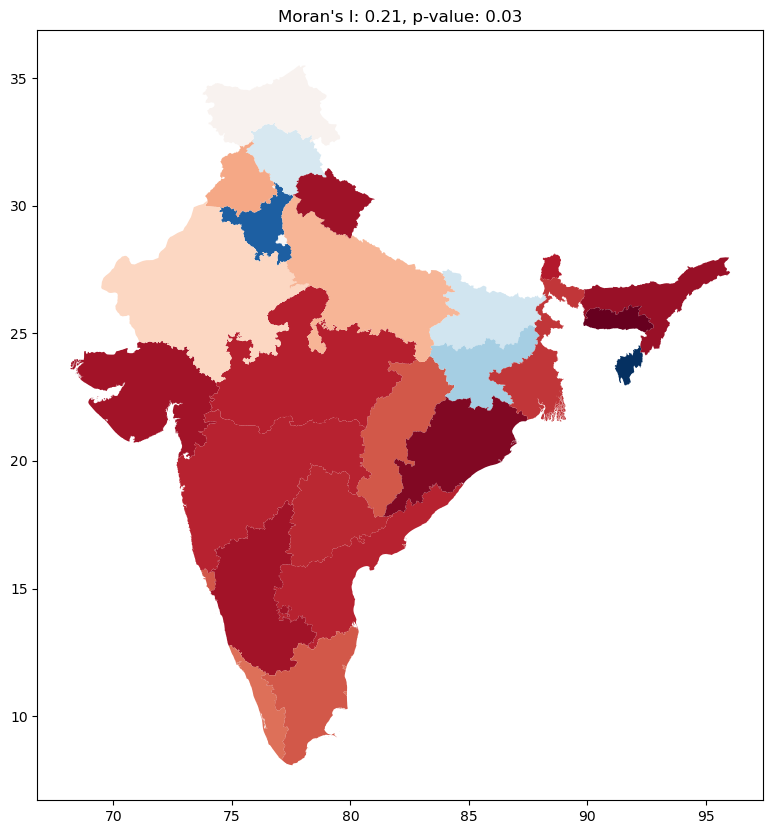

In [397]:
#Spatial Autocorrelation
def plot_spatial_autocorrelation(gdf, column, method='queen'):
    w = create_spatial_weights(gdf, method)
    moran = esda.Moran(gdf[column], w)
    fig, ax = plt.subplots(figsize=(10, 10))
    gdf.plot(column, cmap='RdBu', ax=ax)
    ax.set_title('Moran\'s I: {:.2f}, p-value: {:.2f}'.format(moran.I, moran.p_sim))
    plt.show()

#Plot Spatial Autocorrelation
plot_spatial_autocorrelation(gdf, 'Estimated Unemployment Rate (%)', method='queen')

In [398]:
#Spatial Variability
def get_spatial_variability(gdf, column, method='queen'):
    w = create_spatial_weights(gdf, method)
    return esda.Moran_Local(gdf[column], w)

#Get Spatial Variability
moran_local = get_spatial_variability(gdf, 'Estimated Unemployment Rate (%)', method='queen')
moran_local

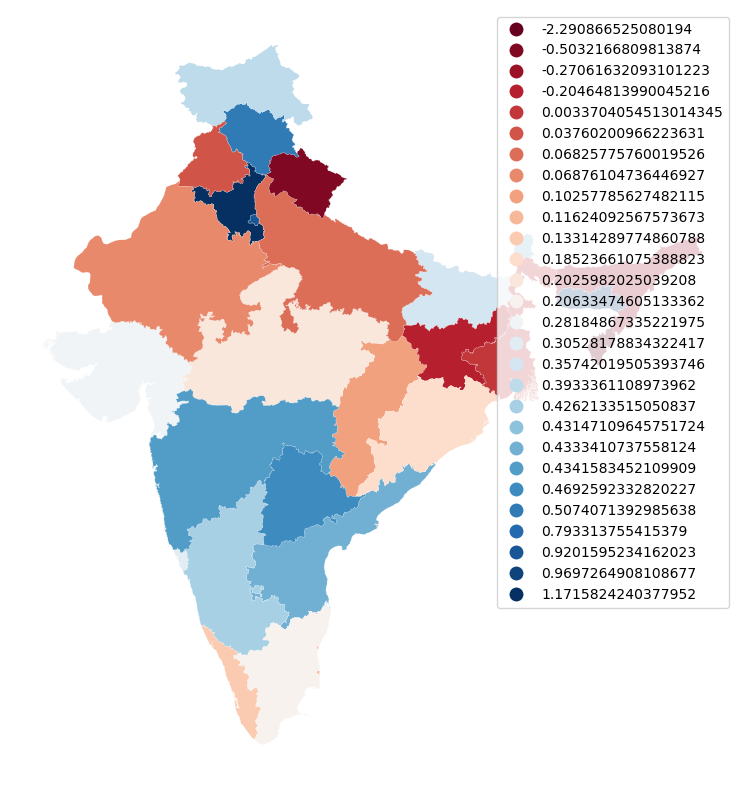

In [399]:
#Plot the Spatial Variability
def plot_spatial_variability(gdf, moran_local):
    fig, ax = plt.subplots(figsize=(10, 10))
    gdf.assign(cl= moran_local.Is).plot(column='cl', categorical=True, k=2, cmap='RdBu', linewidth=0.1, ax=ax, edgecolor='white', legend=True)
    ax.set_axis_off()
    plt.show()

#Plot the Spatial Variability
plot_spatial_variability(gdf, moran_local)

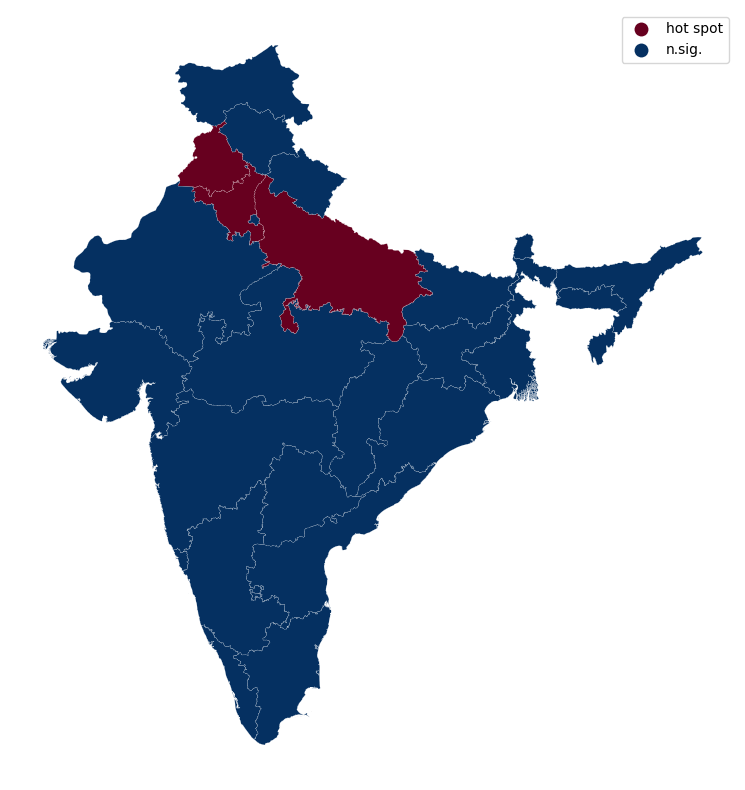

In [400]:
#Spatial Clusters
def get_spatial_clusters(gdf, moran_local):
    sig = moran_local.p_sim < 0.05
    hotspot = moran_local.q==1 * sig
    coldspot = moran_local.q==3 * sig
    doughnut = moran_local.q==2 * sig
    diamond = moran_local.q==4 * sig
    spots = ['n.sig.', 'hot spot']
    labels = [spots[i] for i in hotspot*1]
    gdf['Spatial Clusters'] = labels
    return gdf

#Get Spatial Clusters
gdf = get_spatial_clusters(gdf, moran_local)

#Plot the Spatial Clusters
def plot_spatial_clusters(gdf):
    fig, ax = plt.subplots(figsize=(10, 10))
    gdf.plot(column='Spatial Clusters', categorical=True, k=2, cmap='RdBu', linewidth=0.1, ax=ax, edgecolor='white', legend=True)
    ax.set_axis_off()
    plt.show()

#Plot the Spatial Clusters
plot_spatial_clusters(gdf)

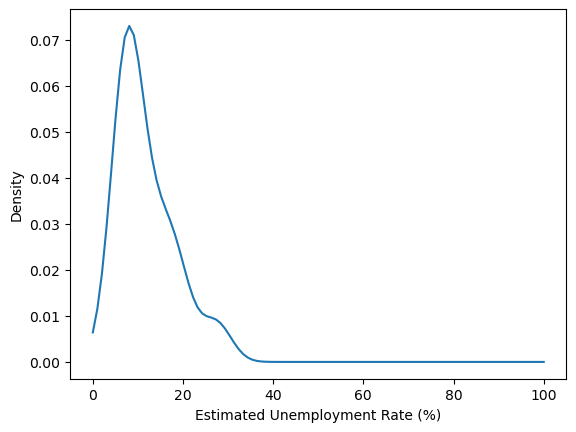

In [401]:
#Kernel Density Estimation
kde = gaussian_kde(gdf['Estimated Unemployment Rate (%)'])
x = np.linspace(0, 100, 100)
plt.plot(x, kde(x))
plt.xlabel('Estimated Unemployment Rate (%)')
plt.ylabel('Density')
plt.show()